In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [15]:
# 데이터 컬럼 정보를 불러옵니다.
df_col = pd.read_csv("data/kadx-utf8-recipe-detail.csv")
df_col.shape

(19, 5)

In [16]:
df_col

,no,pk,type,nameEn,nameKo
0,0.0,Y,NUMBER(40),RCP_SNO,레시피일련번호
1,1.0,N,VARCHAR(200),RCP_TTL,레시피제목
2,2.0,N,VARCHAR(40),CKG_NM,요리명
3,3.0,N,VARCHAR(32),RGTR_ID,등록자ID
4,4.0,N,VARCHAR(64),RGTR_NM,등록자명
5,5.0,N,NUMBER(11),INQ_CNT,조회수
6,6.0,N,NUMBER(11),RCMM_CNT,추천수
7,7.0,N,NUMBER(11),SRAP_CNT,스크랩수
8,8.0,N,VARCHAR(200),CKG_MTH_ACTO_NM,요리방법별명
9,9.0,N,VARCHAR(200),CKG_STA_ACTO_NM,요리상황별명


In [17]:
# 원본 데이터를 불러옵니다.
raw = pd.read_csv("data/kadx-utf8-recipe.csv")
raw.shape

(17, 18)

In [18]:
# 영문 컬럼명을 한글로 변환하기 위한 매핑 딕셔너리를 생성합니다.
col_dict = df_col[["nameEn","nameKo"]].set_index("nameEn")['nameKo'].to_dict()
col_dict

{'RCP_SNO': '레시피일련번호',
 'RCP_TTL': '레시피제목',
 'CKG_NM': '요리명',
 'RGTR_ID': '등록자ID',
 'RGTR_NM': '등록자명',
 'INQ_CNT': '조회수',
 'RCMM_CNT': '추천수',
 'SRAP_CNT': '스크랩수',
 'CKG_MTH_ACTO_NM': '요리방법별명',
 'CKG_STA_ACTO_NM': '요리상황별명',
 'CKG_MTRL_ACTO_NM': '요리재료별명',
 'CKG_KND_ACTO_NM': '요리종류별명',
 'CKG_IPDC': '요리소개',
 'CKG_MTRL_CN': '요리재료내용',
 'CKG_INBUN_NM': '요리인분명',
 'CKG_DODF_NM': '요리난이도명',
 'CKG_TIME_NM': '요리시간명',
 'FIRST_REG_DT': '최초등록일시',
 nan: nan}

In [22]:
# 원본 데이터의 컬럼명을 한글로 변환합니다.
df = raw.rename(columns=col_dict)

In [23]:
# 변환된 데이터의 첫 몇 줄을 확인합니다.
df.head()

,레시피일련번호,레시피제목,요리명,등록자ID,등록자명,조회수,추천수,스크랩수,요리방법별명,요리상황별명,요리재료별명,요리종류별명,요리소개,요리재료내용,요리인분명,요리난이도명,요리시간명,최초등록일시
0,7014691,유아식 반찬 유아 아침대용 햄계란말이밥만들기 계란말이밥 레시피,계란말이밥,14133148,오드리,156,0,3,부침,영양식,달걀/유제품,밑반찬,바쁜 아침 유아식으로 간편하고 만들기 쉬운 야채안먹는 아이들을 위한 계란말이밥 입니다,[재료] 계란 4개| 비엔나 3개| 마늘 1개| 당근 1/6개| 밥 1공기 [양념]...,2인분,초급,15분이내,20231130162213
1,7014692,겨울배추를 활용한 다이어트에 좋은 배추찜 만들기,배추찜,14133148,오드리,256,0,7,찜,일상,채소류,밑반찬,제철을 맞은 속이 꽉찬 배추를 활용한 레시피에요~ 쌈으로 먹어도 맛있지만 배추를 찌...,[재료] 알배기배추 1통 [간장양념] 간장 2T| 식초 1t| 고춧가루 1t| 참기...,3인분,아무나,10분이내,20231130163948
2,7014693,초간단 어묵볶음...,어묵볶음,pingky7080,행복한미야미니맘,784,0,21,볶음,일상,가공식품류,밑반찬,바쁜아침 간단하게 만드는 밥반찬 ...어묵볶음 만드는 레시피입니다.,[재료] 사각어묵 4장| 대파 1대 [양념] 진간장 2큰술| 물 2큰술| 맛술 1큰...,4인분,아무나,10분이내,20231130175445
3,7014694,누구나 할 수 있는 아보카도연어덮밥 만들기,아보카도연어덮밥,62261522,유징,70,0,3,기타,초스피드,해물류,밥/죽/떡,아보카도연어덮밥은 불을 쓸 필요도 없는 요리라서 초보요리로 아주 좋은 메뉴입니당! ?,[재료] 밥 1공기| 아보카도 1/2개| 훈제연어 70g| 양파 1/4개| 계란 노...,1인분,아무나,10분이내,20231130175903
4,7014695,술안주로 좋은 우삼겹 숙주찜 간단레시피,우삼겹숙주찜,14133148,오드리,119,0,2,볶음,술안주,소고기,메인반찬,일끝나고 저녁에 간단하게 술안주하기 좋은 우삼겹숙주찜입니다 레시피가 아주 간편하니 ...,[재료] 우삼겹 600g| 알배추잎 5장| 숙주 1봉 [양념] 참치액 1T| 소금 ...,2인분,초급,15분이내,20231130181914


In [1]:
# 기본 EDA
df.info()

NameError: name 'df' is not defined

In [ ]:
df.describe()

In [ ]:
df.duplicated().sum()

In [ ]:
# 시각화: 조회수, 스크랩수에 대한 분포
sns.histplot(df['조회수'], kde=True)
plt.title('조회수 분포')
plt.show()

sns.histplot(df['스크랩수'], kde=True)
plt.title('스크랩수 분포')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   레시피일련번호  17 non-null     int64 
 1   레시피제목    17 non-null     object
 2   요리명      17 non-null     object
 3   등록자ID    17 non-null     object
 4   등록자명     17 non-null     object
 5   조회수      17 non-null     int64 
 6   추천수      17 non-null     int64 
 7   스크랩수     17 non-null     int64 
 8   요리방법별명   17 non-null     object
 9   요리상황별명   17 non-null     object
 10  요리재료별명   17 non-null     object
 11  요리종류별명   17 non-null     object
 12  요리소개     17 non-null     object
 13  요리재료내용   17 non-null     object
 14  요리인분명    15 non-null     object
 15  요리난이도명   17 non-null     object
 16  요리시간명    12 non-null     object
 17  최초등록일시   17 non-null     int64 
dtypes: int64(5), object(13)
memory usage: 2.5+ KB
데이터 정보:
 None

기본 통계량:
             레시피일련번호         조회수        추천수       스크랩수        최초등록일시
count  1.70000

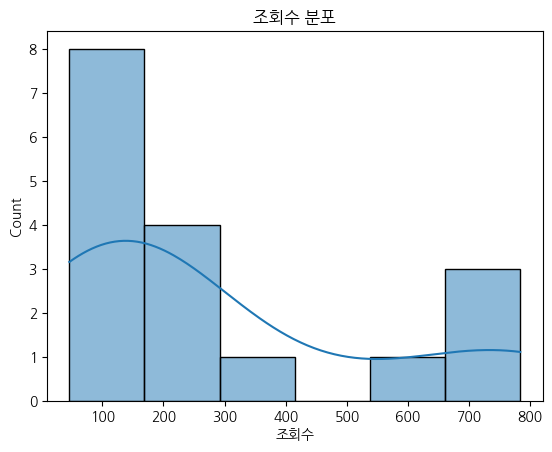

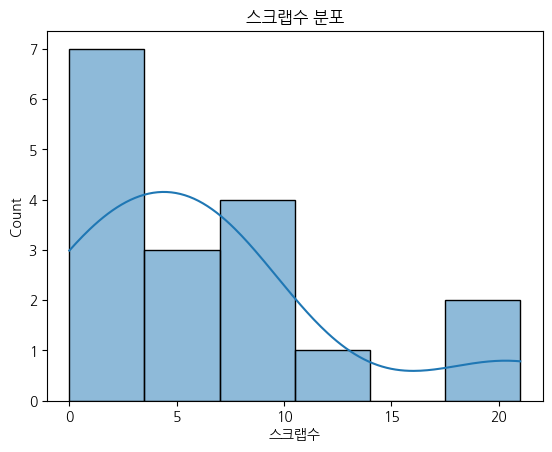

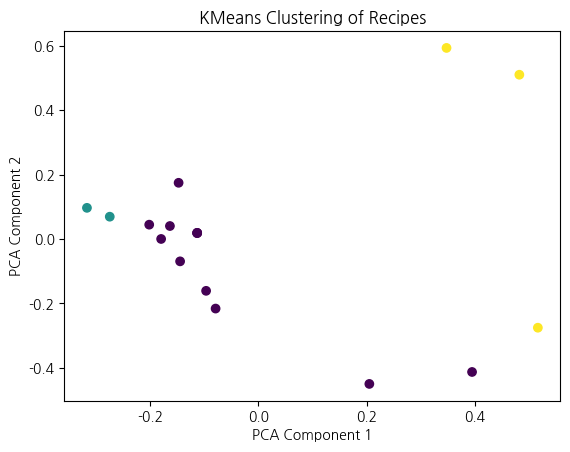


군집별 주요 키워드:
   Cluster 0 Cluster 1 Cluster 2
0     편스토랑에       만들기       만드는
1        아주    길거리토스트      간단하게
2       계란찜     햄치즈계란      밥한공기
3     전자레인지    양배추토스트      깻잎김치
4      만드는법     원팬토스트      간편하게
5       레시피        옛날   깻잎김치하나면
6    황금레시피를      간편하고        뚝딱
7       만들어     야채안먹는      레시피를
8       배추를        바쁜      바쁜아침
9        계란     계란말이밥      어묵볶음

군집별 레시피 개수:
 Cluster
0    12
2     3
1     2
Name: count, dtype: int64


In [24]:
# 텍스트 분석: 요리소개와 재료내용을 TF-IDF로 변환
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['요리소개'])

# 군집 분석: KMeans 사용
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(tfidf_matrix)
df['Cluster'] = kmeans.labels_

# 군집 분석 결과 시각화 (PCA로 차원 축소)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_matrix.toarray())
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Cluster'])
plt.title('KMeans Clustering of Recipes')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 군집별 주요 키워드 나열
def get_top_keywords(tfidf_matrix, kmeans, vectorizer, n_terms=10):
    df_top_keywords = pd.DataFrame()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(kmeans.n_clusters):
        top_keywords = [terms[ind] for ind in order_centroids[i, :n_terms]]
        df_top_keywords[f'Cluster {i}'] = top_keywords
    
    return df_top_keywords

# 군집별 주요 키워드 출력
df_keywords = get_top_keywords(tfidf_matrix, kmeans, vectorizer)
print("\n군집별 주요 키워드:\n", df_keywords)

# 군집별 레시피 개수
print("\n군집별 레시피 개수:\n", df['Cluster'].value_counts())
